# Predicting Heart Disease

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4,suppress=True)
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning) 

## Importing the data

In [2]:
heart = pd.read_csv("../input/heart.csv")
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Looking at the data types

In [3]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


## Getting some information about the variables

In [4]:
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Checking if there are some NANs in the data. This is important for the futher data analysis.

In [5]:
checkNANs = heart.isnull().any(axis=1)  # axis=1 checks every row
sum(checkNANs)

0

#### there seem to be no NANs in the data

## It is important to consider the distributing of the target variable, because if it is imbalanced, the 'accuracy' of the test will not be applicable and we will have to use 'precision' and 'recall'.

In [6]:
heart['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

#### the target variable is quite balanced

## Let's check if the distribution of the variable is relatively normal, because the performance of some models depends on the normality of the input data.

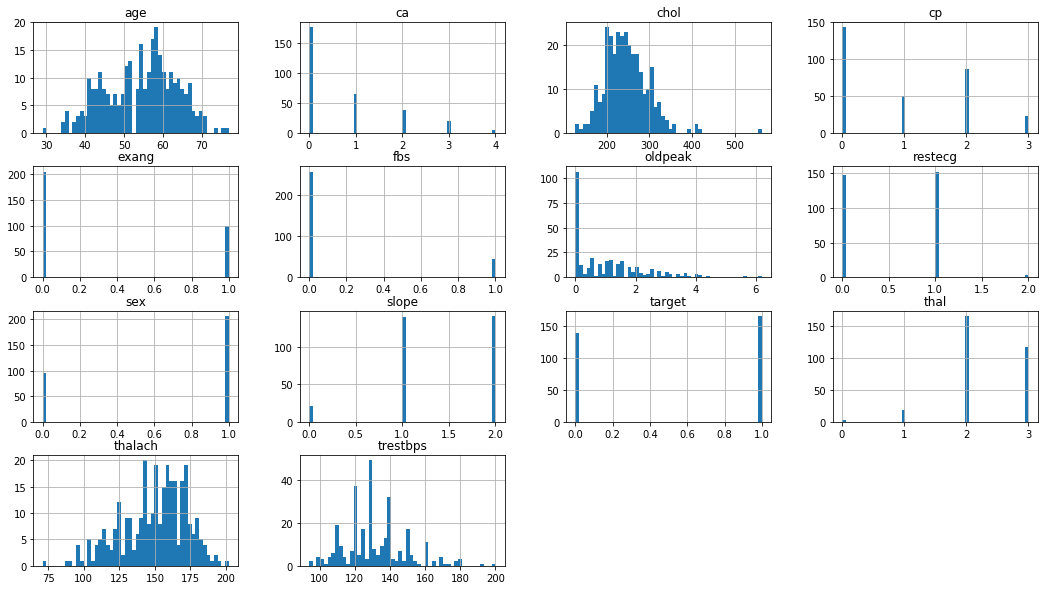

In [7]:
heart.hist(bins = 50, figsize=(18,10)) 
plt.show()

#### non-discrete variables seem to be OK.

## Clearly, some variables are categorical. For example,we have 'cp', which is chest pain *type*. Chest pain types could be, for example, continuous pain, acute pain, pain that exacerbates when breathing etc. If we leave the the 'cp' variable as it is, it will mean that one type of pain is *mathematically* bigger than the other, which, of course, does not make sense. The same applies to 'sex' (are men > women ? :-) Not really.) and I guess also 'exang'. Thus, I will make these variables categorical and change the dataset accordingly.

In [8]:
heart['cp'] = heart['cp'].astype('category')
heart['sex'] = heart['sex'].astype('category')
heart['exang'] = heart['exang'].astype('category')

heart = pd.get_dummies(heart)

## Now I can test the correlation

In [9]:
corr_matrix = heart.corr()
print (corr_matrix['target'].sort_values(ascending = False))

target      1.000000
exang_0     0.436757
thalach     0.421741
slope       0.345877
cp_2        0.316742
sex_0       0.280937
cp_1        0.245879
restecg     0.137230
cp_3        0.086957
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex_1      -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang_1    -0.436757
cp_0       -0.516015
Name: target, dtype: float64


## Before doing anything else, I will divide the dataset into a train and a test set. 
## To the best of my  knowledge, only trees do not require some sort of standartisation, i.e. bringing the data to the similar order of magnitude. So if I plan to use some other method I *must* apply standartisation. The right way to do it, is to scale the train set and then, using the same parameters to the test set. 
## I will be using the GridSearch method when applying SVM and then I will be using Random Forest Classifier 

In [10]:
X = heart.drop('target',axis=1)
y = heart['target']

In [11]:
SVC_train_set_accuracy = []
SVC_test_set_accuracy = []
RFC_train_set_accuracy = []
RFC_test_set_accuracy = []

for _ in range(0,20):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state = np.random.randint(100), stratify=y)
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    param_grid = [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
    grid_search = GridSearchCV(SVC(), param_grid, cv=10)
    grid_search.fit(X_train_scaled, y_train)
    SVC_train_set_accuracy.append(grid_search.best_score_)
    SVC_test_set_accuracy.append(grid_search.score(X_test_scaled,y_test))
    
    forest = RandomForestClassifier(max_features = 3)
    forest.fit(X_train_scaled, y_train)
    RFC_train_set_accuracy.append(forest.score(X_train_scaled, y_train))
    RFC_test_set_accuracy.append(forest.score(X_test_scaled, y_test))


print("SVC training set accuracy: {:.2f} ± {:.2f} ".format(np.array(SVC_train_set_accuracy).mean(),np.array(SVC_train_set_accuracy).std()))
print("SVC test set accuracy: {:.2f} ± {:.2f}".format(np.array(SVC_test_set_accuracy).mean(),np.array(SVC_test_set_accuracy).std())) 
print("RFC training set accuracy: {:.2f} ± {:.2f}".format(np.array(RFC_train_set_accuracy).mean(),np.array(RFC_train_set_accuracy).std()))
print("RFC test set accuracy: {:.2f} ± {:.2f}".format(np.array(RFC_test_set_accuracy).mean(), np.array(RFC_test_set_accuracy).std()))

SVC training set accuracy: 0.83 ± 0.01 
SVC test set accuracy: 0.82 ± 0.04
RFC training set accuracy: 0.99 ± 0.00
RFC test set accuracy: 0.79 ± 0.04


## Notice, that in all statistical results the answer should include the error term  as above.

## Thank you for reading! Comments and corrections are welcome!